In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt 
from itertools import combinations 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
data = pd.read_csv("../data/DataWithLocationCleaned.csv.gz")
df = data.copy()

In [3]:
def getlat(x):
    lat = x.partition(',')[0][1:]
    if lat[0] == "'":
        lat = lat[1:-1]
    return lat

def getlong(x):
    lat = x.partition(',')[2]
    if lat[1] == "'":
        lat = lat[2:-2]
    else:
        lat = lat[1:-1]
    return lat

df['latitude'] = df['position'].apply(lambda x: getlat(x))
df['longitude'] = df['position'].apply(lambda x: getlong(x))
df.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Year,Month,position,latitude,longitude
0,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Truck Containers Full,133,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
1,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Truck Containers Empty,298,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
2,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicles,10383,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
3,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicle Passengers,19459,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
4,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Pedestrians,2,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404


In [19]:
persons = df[df['Measure'].isin(['Bus Passengers','Pedestrians','Personal Vehicle Passengers','Train Passengers'])].reset_index().drop(columns=['index'])
traffic = df[~df['Measure'].isin(['Bus Passengers','Pedestrians','Personal Vehicle Passengers','Train Passengers'])].reset_index().drop(columns=['index'])
ports = df['Port Name'].unique()

In [28]:
## Plot the map of the USA with importance of ports.
import plotly.express as px
import plotly.graph_objects as go


def plotMap(data):
    
    persons_location = data[['position','Value']].groupby('position').sum().reset_index()

    persons_location['latitude'] = persons_location['position'].apply(lambda x: getlat(x))
    persons_location['longitude'] = persons_location['position'].apply(lambda x: getlong(x))

    
    ps = df[['Port Name','position']].drop_duplicates().set_index('position')
    
    persons_location['Ports'] = persons_location.position.apply(lambda x : ', '.join(ps.loc[x].values.flatten()))
    persons_location['text'] = persons_location['Ports'] + '<br>Crossings: ' + (persons_location['Value']/1e6).astype(str)+' million'

    color = "crimson"
    scale = 500000
    

    fig = go.Figure()
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = persons_location['longitude'],
        lat = persons_location['latitude'],
        text = persons_location['text'],
        marker = dict(
            size = persons_location['Value']/scale,
            color = color,
            line_color='rgb(20,20,20)',
            line_width=0.5,
            sizemode = 'area')))

    fig.update_layout(
            title_text = 'US Borders, total inbound persons since 1996<br>(Click legend to toggle traces)',
            showlegend = False,
            geo = dict(
                scope = 'usa',
                landcolor = 'rgb(217, 217, 217)',
            )
        )

    fig.show()
    
plotMap(df)

# Logistic regression

In [209]:
def logistic(X,y,baseRate):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    LR = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)
    LR.fit(X_train,y_train)
    test_score = LR.score(X_test, y_test)
    train_score = LR.score(X_train,y_train)
    print("train_score :",train_score,"test_score =",test_score)
    return [test_score,baseRate]

def encodeOneHot(z,f,i):
    test = z
    baseRate = pd.qcut(test['Value'],q = i, duplicates = 'drop').value_counts()
    print("Base rate :",baseRate.max()/baseRate.sum())
    print()
    test['quant'] = pd.qcut(test['Value'],q = i, duplicates = 'drop')
    print("intervalls for y:")
    print(test['quant'].value_counts())
    print()
    le = LabelEncoder()
    y = le.fit_transform(test["quant"])
    one_hot = OneHotEncoder(categories="auto")
    
    if (('Measure' in f)&('State' in f)):
        f.remove('Measure')
        f.remove('State')
        cat_to_onehot = one_hot.fit_transform(test[["Measure","State"]]).toarray()
        cat_to_onehot = pd.DataFrame(cat_to_onehot)
        X = pd.concat((test[f],cat_to_onehot),axis=1)
        return logistic(X,y,baseRate.max()/baseRate.sum())
    if ('Measure' in f):
        f.remove('Measure')
        cat_to_onehot = one_hot.fit_transform(test[["Measure"]]).toarray()
        cat_to_onehot = pd.DataFrame(cat_to_onehot)
        X = pd.concat((test[f],cat_to_onehot),axis=1)
        return logistic(X,y,baseRate.max()/baseRate.sum())
    if ('State' in f):
        f.remove('State')
        cat_to_onehot = one_hot.fit_transform(test[["State"]]).toarray()
        cat_to_onehot = pd.DataFrame(cat_to_onehot)
        X = pd.concat((test[f],cat_to_onehot),axis=1)
        return logistic(X,y,baseRate.max()/baseRate.sum())
    else :
        X = test[f]
        return logistic(X,y,baseRate)
        
def  computeLogistic(dataset,ports,f,i):
    if (len(f) == 0):
        return
    Zone = dataset[dataset['Port Name'].isin(ports)].reset_index(drop=True)
    return encodeOneHot(Zone,f,i)


In [16]:
#Logistic regression on all values(traffic + persons) and all features with 8 intervalls
computeLogistic(df,ports,['Measure','Port Code','Month','Year','State','latitude','longitude'],8)

Base rate : 0.37521622581421193

intervalls for y:
(-0.001, 4.0]            131015
(4.0, 93.0]               43823
(17529.25, 4447374.0]     43647
(2518.0, 17529.25]        43644
(565.0, 2518.0]           43606
(93.0, 565.0]             43437
Name: quant, dtype: int64

train_score : 0.49514027858822857 test_score = 0.49528173551943866


In [217]:
#Logistic regression on Traffic and all features with 8 intervalls
computeLogistic(traffic,ports,['Measure','Port Code','Month','Year','State','latitude','longitude'],8)

Base rate : 0.37627713578297384

intervalls for y:
(-0.001, 3.0]          87688
(9453.0, 1744349.0]    29130
(1622.0, 9453.0]       29121
(421.0, 1622.0]        29116
(74.0, 421.0]          29045
(3.0, 74.0]            28941
Name: quant, dtype: int64

train_score : 0.4979080844490216 test_score = 0.49816559033663027


[0.49816559033663027, 0.37627713578297384]

In [140]:
#Logistic regression on Persons and all features with 8 intervalls
computeLogistic(persons,ports,['Measure','Port Code','Month','Year','State','latitude','longitude'],8)

Base rate : 0.37606668331453275

intervalls for y:
(-0.001, 11.0]          43673
(62918.0, 4447374.0]    14516
(6943.0, 62918.0]       14516
(1193.0, 6943.0]        14516
(156.0, 1193.0]         14503
(11.0, 156.0]           14407
Name: quant, dtype: int64

train_score : 0.5263174890209248 test_score = 0.5301588668360098


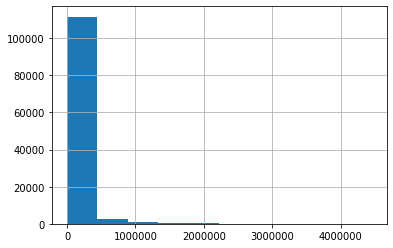

In [128]:
persons['Value'].hist()

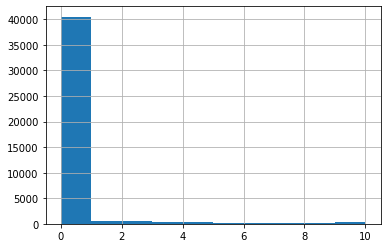

In [129]:
persons['Value'].hist(range=[0,10])

In [222]:
print("Total observations in persons:",persons.shape[0])
print("Total of observation with value = 0:",persons[persons['Value']==0].shape[0])
print("Ratio null value / total observations",persons[persons['Value']==0].shape[0]/persons.shape[0],"%")


Total observations in persons: 116131
Total of observation with value = 0: 40507
Ratio null value / total observations 0.348804367481551 %


As we have a lot of null values (0.34%), the dispersion of values and the number of intervals are biased. It is not possible to create 8 intervals if the 30% of the values are = 0. In addition, the baseRate will also be larger.

To continue, we have decided to focus only on ports with FEW zero values. 

number of ports :  9
number of observations   10147
ratio of null value / total observation :  0.006208731644821129
Base rate : 0.12555435103971618

intervalls for y:
(104.0, 250.0]            1274
(-0.001, 104.0]           1271
(126679.25, 2523598.0]    1269
(31294.5, 126679.25]      1268
(8321.75, 31294.5]        1268
(1756.0, 8321.75]         1268
(600.0, 1756.0]           1265
(250.0, 600.0]            1264
Name: quant, dtype: int64

train_score : 0.5796476530737957 test_score = 0.5926108374384237


[0.5926108374384237, 0.12555435103971618]

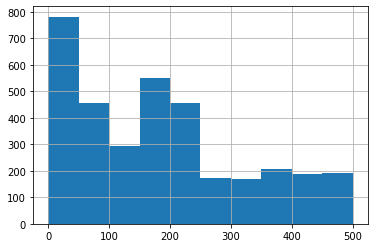

In [224]:
#We create a list of "goods" port : these port will have more than 1100 values not equal to 0.
goods = []
for port in ports:
    if (persons[(persons['Port Name'] == port) &(persons['Value'] != 0)].shape[0]>1100):
        goods.append(port)
print("number of ports : ",len(goods))
print("number of observations  ",persons[persons['Port Name'].isin(goods)].shape[0])
print("ratio of null value / total observation : ",persons[(persons['Port Name'].isin(goods))&(persons['Value'] == 0)].shape[0]/persons[persons['Port Name'].isin(goods)].shape[0])
persons[persons['Port Name'].isin(goods)]['Value'].hist(range=[0,500])
computeLogistic(persons,goods,['Measure','Port Code','Month','Year','State','longitude','latitude'],8)

The histogram shows us a better dispersion of the value. The null value represent only 0.0062 of the total, which is way better. The BaseRate has also decreased. All this allows us to create intervals with the same number of samples.

In [70]:
#Train / test split lineary with dates
#Stratify the data
##create Map of the USA with test_score error <- BIAISééé



In [134]:
persons = persons.sort_values(by=['Date']).reset_index(drop=True)
persons.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Year,Month,position,latitude,longitude
0,Walhalla,North Dakota,3407,US-Canada Border,1996-01-01,Bus Passengers,19,1996,1,"(48.923328, -97.918148)",48.923328,-97.918148
1,Piegan,Montana,3316,US-Canada Border,1996-01-01,Bus Passengers,46,1996,1,"(48.4346971, -112.6945072)",48.4346971,-112.6945072
2,Antler,North Dakota,3413,US-Canada Border,1996-01-01,Personal Vehicle Passengers,1576,1996,1,"(48.9708532, -101.2823803)",48.9708532,-101.2823803
3,Ogdensburg,New York,701,US-Canada Border,1996-01-01,Pedestrians,0,1996,1,"(44.694285, -75.486374)",44.694285,-75.486374
4,St. John,North Dakota,3405,US-Canada Border,1996-01-01,Personal Vehicle Passengers,3278,1996,1,"(48.9444517, -99.7109743)",48.9444517,-99.7109743


To go further, we try to apply models on each of the 9 ports selected above

In [225]:
error_good = []
for good in goods:
    error_good.append([good,computeLogistic(persons,[good],['Measure','Port Code','Month','Year','State','latitude','longitude'],8)])

Base rate : 0.13120567375886524

intervalls for y:
(78.0, 372.0]             148
(-0.001, 78.0]            144
(136553.375, 307761.0]    141
(11205.75, 136553.375]    141
(4365.75, 11205.75]       141
(3250.0, 4365.75]         141
(2188.625, 3250.0]        141
(372.0, 2188.625]         131
Name: quant, dtype: int64

train_score : 0.5554323725055432 test_score = 0.5398230088495575
Base rate : 0.125

intervalls for y:
(191824.5, 550685.0]    141
(48494.75, 191824.5]    141
(24992.5, 48494.75]     141
(6138.5, 24992.5]       141
(2724.875, 6138.5]      141
(581.0, 2724.875]       141
(155.875, 581.0]        141
(-0.001, 155.875]       141
Name: quant, dtype: int64

train_score : 0.5920177383592018 test_score = 0.5929203539823009
Base rate : 0.125

intervalls for y:
(1018693.875, 2523598.0]    141
(314691.0, 1018693.875]     141
(76280.75, 314691.0]        141
(44584.0, 76280.75]         141
(19083.625, 44584.0]        141
(5289.25, 19083.625]        141
(2433.25, 5289.25]          141
(36

In [226]:
error_good_final = []
for e in error_good:
    error_good_final.append([e[0],e[1][0],e[1][1]])

,Test Score,Base Rate
Port Name,,
Portal,0.362832,0.127660
Eastport_ID,0.384956,0.135879
Jackman,0.442478,0.126886
International Falls-Ranier,0.477876,0.131322
Sweetgrass,0.508850,0.128546
Sumas,0.539823,0.131206
Champlain-Rouses Point,0.592920,0.125000
Buffalo-Niagara Falls,0.601770,0.125000
Otay Mesa,0.650442,0.133984


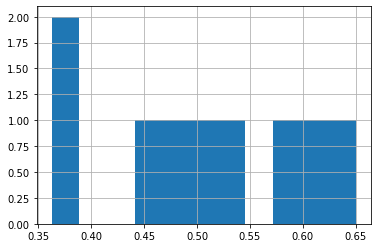

In [227]:
best =  pd.DataFrame(data = error_good_final,columns = ['Port Name','Test Score','Base Rate'])
best = best.set_index('Port Name')
best['Test Score'].hist(bins = 11)
best.sort_values(by=['Test Score'])

Otay Mesa is the port with the less test_error in the non-biaised one. 

Let's find which variable influence the most the Value

In [229]:
#Logitistic regression whith all features
#N.b: Port Code, State, latitude and longitude should not have effect on the value because it's always the same values (one port)
computeLogistic(persons,['Otay Mesa'],['Measure','Port Code','Month','Year','State','latitude','longitude'],8)

Base rate : 0.13398402839396628

intervalls for y:
(-0.001, 38.0]            151
(826016.75, 1252553.0]    141
(421228.0, 826016.75]     141
(144240.25, 421228.0]     141
(15995.5, 45385.0]        141
(325.5, 15995.5]          141
(45385.0, 144240.25]      140
(38.0, 325.5]             131
Name: quant, dtype: int64

train_score : 0.6725860155382908 test_score = 0.6327433628318584


[0.6327433628318584, 0.13398402839396628]

In [231]:
#Logitistic regression whitout measure
computeLogistic(persons,['Otay Mesa'],['Port Code','Month','Year','State','latitude','longitude'],8)

Base rate : 0.13398402839396628

intervalls for y:
(-0.001, 38.0]            151
(826016.75, 1252553.0]    141
(421228.0, 826016.75]     141
(144240.25, 421228.0]     141
(15995.5, 45385.0]        141
(325.5, 15995.5]          141
(45385.0, 144240.25]      140
(38.0, 325.5]             131
Name: quant, dtype: int64

train_score : 0.1997780244173141 test_score = 0.18584070796460178


[0.18584070796460178, 0.13398402839396628]

It seems like that the measure is the main variable that can predict the value of crossing people to the border of Otay Mesa : the test score increase by almost 0,5 if we add measure to the regression

# Test part

In [216]:
test = ['Measure','Month','Year']
final = []
for L in range(0, len(test)+1):
    for subset in combinations(test, L):
        if (len(subset)!=0):
            for i in range(0,len(subset))
                final.append(subset[0])
final
#computeLogistic(persons,['Otay Mesa'],np.asarray(subset),8)

['Measure', 'Month', 'Year', 'Measure', 'Measure', 'Month', 'Measure']

# Linear Regression

In order to make a linear regression, we have to manage to take the log of the y(Value)

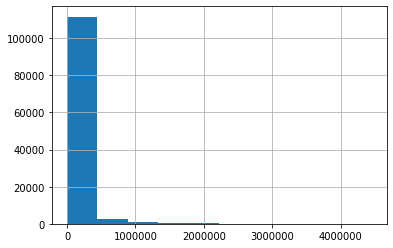

In [93]:
y = persons['Value']
y.hist()

In [94]:
y = np.log(persons['Value']+1)

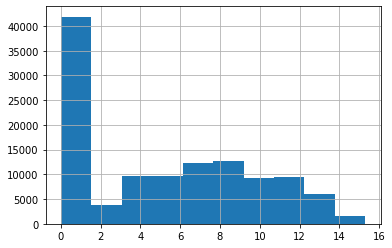

In [95]:
y.hist()

In [119]:
def linearRegression(f):
    one_hot = OneHotEncoder(categories="auto")
    cat_to_onehot = 0
    if (('Measure' in f)&('State' in f)):
        f.remove('Measure')
        f.remove('State')
        cat_to_onehot = one_hot.fit_transform(persons[["Measure","State"]]).toarray()
        cat_to_onehot = pd.DataFrame(cat_to_onehot)
        X = persons[f]
        X = pd.concat((X,cat_to_onehot),axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        iowa_model = LinearRegression()
        iowa_model.fit(X_train,y_train)
        test_score = iowa_model.score(X_test, y_test)
        train_score = iowa_model.score(X_train,y_train)
        return print("train_score :",train_score,"test_score =",test_score)
    if (('Measure' in f)):
        f.remove('Measure')
        cat_to_onehot = one_hot.fit_transform(persons[["Measure"]]).toarray()
        cat_to_onehot = pd.DataFrame(cat_to_onehot)
        X = persons[f]
        X = pd.concat((X,cat_to_onehot),axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        iowa_model = LinearRegression()
        iowa_model.fit(X_train,y_train)
        test_score = iowa_model.score(X_test, y_test)
        train_score = iowa_model.score(X_train,y_train)
        return print("train_score :",train_score,"test_score =",test_score)
    if (('State' in f)):
        f.remove('State')
        cat_to_onehot = one_hot.fit_transform(persons[["State"]]).toarray()
        cat_to_onehot = pd.DataFrame(cat_to_onehot)
        X = persons[f]
        X = pd.concat((X,cat_to_onehot),axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        iowa_model = LinearRegression()
        iowa_model.fit(X_train,y_train)
        test_score = iowa_model.score(X_test, y_test)
        train_score = iowa_model.score(X_train,y_train)
        return print("train_score :",train_score,"test_score =",test_score)
    else:
        X = persons[f]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        iowa_model = LinearRegression()
        iowa_model.fit(X_train,y_train)
        test_score = iowa_model.score(X_test, y_test)
        train_score = iowa_model.score(X_train,y_train)
        return print("train_score :",train_score,"test_score =",test_score)

In [120]:
linearRegression(['Port Code','Month','Year','latitude','longitude','Measure'])

train_score : 0.5513436790824084 test_score = 0.5476095105150889


In [121]:
linearRegression(['Month'])

train_score : 5.1143659171692946e-05 test_score = -5.077273833298257e-05


In [122]:
linearRegression(['Year'])

train_score : 0.001046010558412802 test_score = 4.569223230299624e-05


In [123]:
linearRegression(['Port Code'])

train_score : 0.00873590306661265 test_score = 0.007144077694610118


In [124]:
linearRegression(['latitude'])

train_score : 0.10283460142788503 test_score = 0.09784357166525492


In [125]:
linearRegression(['longitude'])

train_score : 2.838675522565115e-05 test_score = -6.601288111007797e-05


In [126]:
linearRegression(['State'])

train_score : 0.15483684622743454 test_score = 0.14642965906152683


In [127]:
linearRegression(['Measure'])

train_score : 0.4431646622871242 test_score = 0.4408558053896519
